In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from shapely.geometry import mapping, Polygon, MultiPolygon, LineString, MultiLineString

import requests
from io import BytesIO
import gzip
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import geometry_mask, shapes
from scipy.interpolate import NearestNDInterpolator
import startinpy
from rasterio import Affine
from shapely.geometry import shape,box, mapping
from rasterio.crs import CRS
from scipy.ndimage import label
import uuid
from rtree import index
import ezdxf
import json
from shapely.affinity import translate
from rasterio.enums import Resampling
from rasterio.warp import reproject

In [16]:

def write_output(dataset, crs, output, transform, name, change_nodata=False):
    '''
    Writes a numpy array to a GeoTIFF file using rasterio.

    Parameters:
        dataset        :        Rasterio or laspy dataset (for metadata).
        crs            :        Coordinate Reference System for the output raster.
        output (np.ndarray):    Output numpy array grid to write.
        transform      :        Affine transform mapping pixel to spatial coordinates.
        name (str)     :        Output filename (including path).
        change_nodata (bool):   If True, use nodata value -9999; else use dataset's nodata.

    Returns:
        None
    '''
    output_file = name

    output = np.squeeze(output)
    # Set the nodata value: use -9999 if nodata_value is True or dataset does not have nodata.
    if change_nodata:
        nodata_value = -9999
    else:
        try:
            # TO DO: CHANGE THIS TO JUST INPUTTING A NODATA VALUE, NO NEED FOR THE WHOLE DATASET IN THIS FUNCTION
            nodata_value = dataset.nodata
            if nodata_value is None:
                raise AttributeError("No no data value found in dataset.")
        except AttributeError as e:
            print(f"Warning: {e}. Defaulting to -9999.")
            nodata_value = -9999

    # output the dataset
    with rasterio.open(output_file, 'w',
                       driver='GTiff',
                       height=output.shape[0],  # Assuming output is (rows, cols)
                       width=output.shape[1],
                       count=1,
                       dtype=np.float32,
                       crs=crs,
                       nodata=nodata_value,
                       transform=transform) as dst:
        dst.write(output, 1)
    print("File written to '%s'" % output_file)

def edit_bounds(bounds, buffer, shrink=False):
    '''
    Expands or shrinks bounding box coordinates by a buffer amount.

    Parameters:
        bounds (tuple): Bounding box as (min_x, min_y, max_x, max_y).
        buffer (float): Amount to expand or shrink the bounding box.
        shrink (bool):  If True, shrink the bounds by buffer; else expand (default False).

    Returns:
        tuple: Modified bounding box as (min_x, min_y, max_x, max_y).
    '''
    min_x, min_y, max_x, max_y = bounds

    if shrink:
        return (
            min_x + buffer,
            min_y + buffer,
            max_x - buffer,
            max_y - buffer
        )
    else:
        return (
            min_x - buffer,
            min_y - buffer,
            max_x + buffer,
            max_y + buffer
        )


class DEMS:
    '''
    Class for handling Digital Elevation Models (DEM) including DTM and DSM,
    fetching AHN data via WCS, filling missing data, resampling, cropping,
    and integrating building footprints for urban terrain modeling.

    Attributes:
    - buffer (float):                           Buffer size in meters for bbox expansion.
    - bbox (tuple):                             Bounding box coordinates (xmin, ymin, xmax, ymax).
    - bufferbbox (tuple):                       Buffered bounding box expanded by buffer.
    - building_data (list):                     List of building geometries and attributes.
    - resolution (float):                       Desired output raster resolution in meters.
    - user_building_data (list):                User-provided building data.
    - output_dir (str):                         Directory to save output files.
    - bridge (bool):                            Whether to include 'overbruggingsdeel' data in the DSM.
    - resampling (rasterio.enums.Resampling):   Resampling method for raster operations.
    - crs (CRS):                                Coordinate reference system, default EPSG:28992.
    - dtm (np.ndarray):                     Digital Terrain Model raster data.
    - dsm (np.ndarray):                     Digital Surface Model raster data.
    - transform (Affine):                       Affine transform for the rasters.
    - og_dtm (np.ndarray):                  Original DTM before modifications.
    - og_dsm (np.ndarray):                  Original DSM before modifications.
    - is3D (bool):                              Flag indicating if DSM is 3D.
    '''
    def __init__(self, bbox, building_data, resolution=0.5, bridge=False, resampling=Resampling.cubic_spline, output_dir="output"):
        '''
        Initialize the DEM builder object.

        Parameters:
            bbox (tuple):                           Bounding box coordinates (xmin, ymin, xmax, ymax).
            building_data (list):                   Building geometries and data.
            resolution (float):                     Desired output resolution in meters (default 0.5).
            bridge (bool):                          Whether to include  'overbruggingsdeel' geometries (default False).
            resampling (rasterio.enums.Resampling): Resampling method (default cubic_spline).
            output_dir (str):                       Directory for output files (default "output").

        Returns:
            None
        '''
        self.buffer = 2
        self.bbox = bbox
        self.bufferbbox = edit_bounds(bbox, self.buffer)
        self.building_data = building_data
        self.resolution = resolution
        self.user_building_data = []
        self.output_dir = output_dir
        self.bridge = bridge
        self.resampling = resampling
        self.crs = (CRS.from_epsg(28992))
        self.dtm, self.dsm, self.transform = self.create_dem(bbox)
        self.og_dtm, self.og_dsm = self.dtm, self.dsm
        self.is3D = False

    @staticmethod
    def fetch_ahn_wcs(bufferbbox, output_file, coverage="dtm_05m", wcs_resolution=0.5):
        '''
        Fetch AHN WCS data for a given buffered bounding box and save as GeoTIFF.

        Parameters:
            bufferbbox (tuple):     Buffered bounding box (xmin, ymin, xmax, ymax).
            output_file (str):      Output filepath for the GeoTIFF (default "output/dtm.tif").
            coverage (str):         Coverage layer name, e.g. "dtm_05m" or "dsm_05m" (default "dtm_05m").
            wcs_resolution (float): Resolution of WCS data in meters (default 0.5).

        Returns:
            tuple or None: (rasterio dataset object, numpy array of raster data) if successful, else None.
        '''

        # Calculate width and height from bbox and resolution
        width = int((bufferbbox[2] - bufferbbox[0]) / wcs_resolution)
        height = int((bufferbbox[3] - bufferbbox[1]) / wcs_resolution)

        # WCS Service URL
        WCS_URL = "https://service.pdok.nl/rws/ahn/wcs/v1_0"

        # Construct query parameters
        params = {
            "SERVICE": "WCS",
            "VERSION": "1.0.0",
            "REQUEST": "GetCoverage",
            "FORMAT": "GEOTIFF",
            "COVERAGE": coverage,
            "BBOX": f"{bufferbbox[0]},{bufferbbox[1]},{bufferbbox[2]},{bufferbbox[3]}",
            "CRS": "EPSG:28992",
            "RESPONSE_CRS": "EPSG:28992",
            "WIDTH": str(width),
            "HEIGHT": str(height)
        }

        # Send GET request to fetch the data
        response = requests.get(WCS_URL, params=params, headers={"User-Agent": "Mozilla/5.0"})

        if response.status_code == 200:
            with open("temp.tif", "wb") as f:
                f.write(response.content)

            with rasterio.open("temp.tif", "r") as f:
                # TO DO: test if this is still needed after fixing the libraries
                gdal_translate_command = f"gdal_translate -of GTiff -a_srs EPSG:28992 temp.tif {output_file}"
                os.system(gdal_translate_command)

            try:
                with rasterio.open(output_file) as dataset:
                    array = dataset.read(1)
                    old_nodata = dataset.nodata
                    new_nodata = -9999
                    array[array == old_nodata] = new_nodata

                    with rasterio.open(output_file, 'r+') as dst:
                        dst.write(array, 1)
                        dst.nodata = new_nodata

            except Exception as e:
                print(f"Error reading or modifying raster: {e}")
                return None

            # Delete the temporary file after use
            if os.path.exists("temp.tif"):
                os.remove("temp.tif")

            return dst, array

        else:
            print(f"Failed to fetch AHN data: HTTP {response.status_code}")
            return None

    @staticmethod
    def extract_center_cells(geo_array, no_data=-9999):
        '''
        Extract the values of each cell in the input data and save these with the x and y (row and col)
        indices. Thereby, make sure that the corners of the dataset are filled for a full coverage triangulation
        in the next step.

        Parameters:
            geo_array (np.ndarray):         Raster data array.
            no_data (int):                  No data value to identify invalid cells (default -9999).

        Returns:
            list:                           List of [x, y, z] cell values with corners interpolated if no data.
        '''
        # Get the indices of the rows and columns
        rows, cols = np.indices(geo_array.shape)

        # Identify corner coordinates
        corners = {
            "top_left": (0, 0),
            "top_right": (0, geo_array.shape[1] - 1),
            "bottom_left": (geo_array.shape[0] - 1, 0),
            "bottom_right": (geo_array.shape[0] - 1, geo_array.shape[1] - 1)
        }

        # Mask for valid center cells (non-no_data)
        valid_center_cells = (geo_array != no_data)

        # Extract x, y, z values for valid cells
        x_valid = cols[valid_center_cells]
        y_valid = rows[valid_center_cells]
        z_valid = geo_array[valid_center_cells]

        # Create interpolator from valid points
        interpolator = NearestNDInterpolator(list(zip(x_valid, y_valid)), z_valid)

        # Check each corner for no data and interpolate if necessary
        for corner_name, (row, col) in corners.items():
            if geo_array[row, col] == no_data:
                # Interpolate the nearest valid value
                geo_array[row, col] = interpolator((col, row))

        # Extract non-no_data and center cells again after filling corners
        valid_center_cells = (geo_array != no_data)

        # Extract final x, y, z values after filling corners
        x_filled = cols[valid_center_cells]
        y_filled = rows[valid_center_cells]
        z_filled = geo_array[valid_center_cells]

        # Prepare final list of [x, y, z]
        xyz_filled = []
        for x_i, y_i, z_i in zip(x_filled, y_filled, z_filled):
            xyz_filled.append([x_i, y_i, z_i])

        return xyz_filled

    def crop_to_bbox(self, array, transform):
        '''
        Crop a buffered raster array to the original bounding box.

        Parameters:
            array (np.ndarray): Raster data array with buffer.
            transform (Affine): Affine transform matrix of input array.

        Returns:
            cropped_array (np.ndarray):     Cropped raster array.
            new_transform (Affine):         New Affine transform matrix for cropped raster.
        '''

        # Compute the window from the full buffered transform, for the smaller (target) bbox
        crop_pixels = int(self.buffer / self.resolution)

        # Crop array: remove buffer from all sides
        print(crop_pixels)
        cropped_array = array[crop_pixels:-crop_pixels, crop_pixels:-crop_pixels]
        print(cropped_array.shape)

        # Adjust transform: move origin by number of removed pixels
        new_transform = transform * Affine.translation(crop_pixels, crop_pixels)

        return cropped_array, new_transform

    def resample_raster(self, input_array, input_transform, input_crs, output_resolution):
        '''
        Resample a raster to a different resolution.

        Parameters:
            input_array (np.ndarray): Input raster data.
            input_transform (Affine): Affine transform of input raster.
            input_crs (CRS): Coordinate Reference System of input raster.
            output_resolution (float): Desired output resolution in meters.

        Returns:
            resampled_array (np.ndarray):     Resampled raster array.
            new_transform (Affine):           New Affine transform matrix for resampled raster.
        '''
        height, width = input_array.shape
        new_width = int((width * input_transform.a) / output_resolution)
        new_height = int((height * -input_transform.e) / output_resolution)

        new_transform = rasterio.transform.from_origin(
            input_transform.c, input_transform.f, output_resolution, output_resolution
        )

        resampled_array = np.empty((new_height, new_width), dtype=input_array.dtype)

        reproject(
            source=input_array,
            destination=resampled_array,
            src_transform=input_transform,
            src_crs=input_crs,
            dst_transform=new_transform,
            dst_crs=input_crs,
            resampling=self.resampling
        )

        return resampled_array, new_transform

    def fill_raster(self, geo_array, nodata_value, transform):
        '''
        Fill no-data values in a raster using Laplace interpolation.

        Parameters:
            geo_array (np.ndarray):     Cropped raster data array.
            nodata_value (int):         No-data value to replace NaNs after interpolation.
            transform (Affine):         Affine transform matrix of the raster.

        Returns:
            new_data(np.ndarray):       Filled raster array with no-data values replaced.
        '''

        # creating delaunay
        points = self.extract_center_cells(geo_array, no_data=nodata_value)
        dt = startinpy.DT()
        dt.insert(points, "BBox")

        # for interpolation, grid of all column and row positions, excluding the first and last rows/cols
        cols, rows = np.meshgrid(
            np.arange(0, geo_array.shape[1]),
            np.arange(0, geo_array.shape[0])
        )

        # flatten the grid to get a list of all (col, row) locations
        locs = np.column_stack((cols.ravel(), rows.ravel()))
        interpolated_values = dt.interpolate({"method": "Laplace"}, locs)

        # reshape interpolated grid back to original
        interpolated_grid = np.reshape(interpolated_values, (geo_array.shape[0], geo_array.shape[1]))

        # fill new_data with interpolated values
        new_data= interpolated_grid
        new_data = np.where(np.isnan(new_data), nodata_value, new_data)

        return new_data

    def replace_buildings(self, filled_dtm, dsm_buildings, buildings_geometries, transform, bridge):
        '''
        Replace filled DTM values with DSM building heights where buildings exist.

        Parameters:
            filled_dtm (np.ndarray):        Filled, cropped DTM array.
            dsm_buildings (np.ndarray):     Filled, cropped DSM array with buildings.
            buildings_geometries (list):    List of building geometries (dict or GeoJSON features).
            transform (Affine):             Affine transform matrix of the rasters.
            bridge (bool):                  Whether to include 'overbrugginsdeel' geometries.

        Returns:
            final_dsm (np.ndarray):         Final DSM array combining ground and building heights.
        '''
        geometries = [shape(building['geometry']) for building in buildings_geometries if 'geometry' in building]
        bridging_geometries = []
        if bridge is True:
            bridge_crs = "http://www.opengis.net/def/crs/EPSG/0/28992"
            url = f"https://api.pdok.nl/lv/bgt/ogc/v1/collections/overbruggingsdeel/items?bbox={self.bbox[0]},{self.bbox[1]},{self.bbox[2]},{self.bbox[3]}&bbox-crs={bridge_crs}&crs={bridge_crs}&limit=1000&f=json"
            response = requests.get(url)
            if response.status_code == 200:
                bridging_data = response.json()
                if "features" in bridging_data:  # Ensure data contains geometries
                    bridging_geometries = [shape(feature['geometry']) for feature in bridging_data["features"] if
                                           'geometry' in feature]
            else:
                print(f"Error fetching bridges: {response.status_code}, {response.text}")

        # Ensure mask has same shape as filled_dtm
        all_geometries = bridging_geometries + geometries
        building_mask = geometry_mask(all_geometries, transform=transform, invert=False, out_shape=filled_dtm.shape)

        # Get shape differences
        dtm_shape = filled_dtm.shape
        dsm_shape = dsm_buildings.shape

        if dtm_shape != dsm_shape:
            # Compute the cropping offsets
            row_diff = dsm_shape[0] - dtm_shape[0]
            col_diff = dsm_shape[1] - dtm_shape[1]

            # Ensure even cropping from all sides (center alignment)
            row_start = row_diff // 2
            col_start = col_diff // 2
            row_end = row_start + dtm_shape[0]
            col_end = col_start + dtm_shape[1]

            # Crop dsm_buildings to match filled_dtm
            dsm_buildings = dsm_buildings[row_start:row_end, col_start:col_end]

        # Apply the mask
        final_dsm = np.where(building_mask, filled_dtm, dsm_buildings)
        return final_dsm

    def create_dem(self, bbox):
        '''
        Create Digital Elevation Model (DEM) from AHN data with optional building and overbrugginsdeel data.

        Parameters:
            bbox (tuple):       Bounding box coordinates (xmin, ymin, xmax, ymax).

        Returns:
            cropped_dtm (np.ndarray):   Filled, cropped DTM array.
            cropped_dsm (np.ndarray):   Cropped DSM array with buildings and building heights, optional output.
            transform (Affine):   Affine transform matrix of the rasters.
         '''

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        # --- Fetch DTM ---
        dtm_dst, dtm_array = self.fetch_ahn_wcs(
            self.bufferbbox, output_file="output/dtm_fetched.tif", coverage="dtm_05m", wcs_resolution=0.5
        )
        transform = dtm_dst.transform
        filled_dtm  = self.fill_raster(dtm_array, dtm_dst.nodata, transform)

        # --- Fetch DSM if buildings are used ---
        if self.building_data:
            dsm_dst, dsm_array = self.fetch_ahn_wcs(
                self.bufferbbox, output_file="output/dsm_fetched.tif", coverage="dsm_05m", wcs_resolution=0.5
            )
            filled_dsm = self.fill_raster(dsm_array, dsm_dst.nodata, transform)
            final_dsm = self.replace_buildings(
                filled_dtm, filled_dsm, self.building_data, transform, self.bridge
            )
        else:
            final_dsm = filled_dtm
        # --- Resample if needed ---
        if self.resolution != 0.5:
            filled_dtm, resamp_transform = self.resample_raster(
                filled_dtm, transform, dtm_dst.crs, self.resolution
            )

            if final_dsm is not None:
                final_dsm, _ = self.resample_raster(
                    final_dsm, transform, dtm_dst.crs, self.resolution
                )

            transform = resamp_transform

        # --- Crop the arrays to the bounding box after interpolation ---
        cropped_dtm, transform = self.crop_to_bbox(filled_dtm, transform)

        if final_dsm is not None:
            cropped_dsm, _ = self.crop_to_bbox(final_dsm, transform)

        # --- Write outputs ---
        write_output(dtm_dst, self.crs, cropped_dtm, transform, f"{self.output_dir}/final_dtm1.tif")

        if final_dsm is not None:
            write_output(dtm_dst, self.crs, cropped_dsm, transform, f"{self.output_dir}/final_dsm1.tif")

        return cropped_dtm, cropped_dsm if final_dsm is not None else cropped_dtm, transform

    def update_dsm(self, user_buildings, user_array=None, user_arrays=None, higher_buildings=None):
        '''
        Update the DSM with new user building heights, supporting both 2D and 3D DSM arrays.

        Parameters:
            user_buildings (list):                          List of user building data dictionaries with geometries.
            user_array (np.ndarray, optional):              Single 2D array with building height data.
            user_arrays (list of np.ndarray, optional):     List of arrays representing multiple DSM layers.
            higher_buildings (list, optional):              List of user buildings with additional height layers.

        Returns:
            None
        '''
        self.is3D = user_arrays is not None

        if isinstance(self.dsm, np.ndarray):
            self.dsm = [self.dsm]

        self.dsm = self.dsm + [np.full_like(self.dtm, np.nan) for _ in range(len(self.dsm), len(user_arrays))]

        for building in user_buildings:
            if 'geometry' in building:
                geom = shape(building['geometry'])

                mask = geometry_mask([geom], transform=self.transform, invert=True, out_shape=self.dtm.shape)
                # Find the minimum value within the mask
                min_value = np.min(self.dtm[mask])

                if not self.is3D:
                    self.dsm[mask] = user_array[mask] + min_value
                else:
                    self.dsm[0][mask] = user_arrays[0][mask] + min_value

                    if higher_buildings is not None:
                        new_build = next(
                            (b for b in higher_buildings if b['parcel_id'] == building['parcel_id']),
                            None
                        )

                        if new_build and 'geometry' in new_build:
                            new_geom = shape(new_build["geometry"])
                            new_mask = geometry_mask([new_geom], transform=self.transform, invert=True,
                                                     out_shape=self.dtm.shape)

                            for i in range(1, len(user_arrays)):
                                self.dsm[i][new_mask] = user_arrays[i][new_mask] + min_value

    def remove_buildings(self, remove_list, remove_user_list, building_data, user_building_data, user_buildings_higher=None):
        '''
        Remove specified buildings from DSM by replacing their areas with DTM values.

        Parameters:
            remove_list (list):                         List of parcel IDs to remove from the main building dataset.
            remove_user_list (list):                    List of parcel IDs to remove from the user building dataset.
            building_data (list):                       List of main building data dictionaries.
            user_building_data (list):                  List of user building data dictionaries.
            user_buildings_higher (list, optional):     List of user buildings with higher layers to be removed as well.

        Returns:
            None
        '''

        remove_set = set(remove_list)
        remove_user_set = set(remove_user_list)
        # Find buildings to remove from both datasets
        to_remove = [building for building in building_data if building['parcel_id'] in remove_set]
        print("Parcel IDs being checked (to_remove):",
              [building['parcel_id'] for building in building_data])

        to_remove_user = [building for building in user_building_data if building['parcel_id'] in remove_user_set]
        print("Parcel IDs being checked (to_remove_user):",
              [building['parcel_id'] for building in user_building_data])

        remove_all = to_remove + to_remove_user

        # Extract geometries for mask creation
        geometries = [shape(building['geometry']) for building in remove_all if 'geometry' in building]

        # Create the removal mask if there are geometries
        if geometries:
            remove_building_mask = geometry_mask(geometries, transform=self.transform, invert=False,
                                                 out_shape=self.dtm.shape)
            if not self.is3D:
                self.dsm[...] = np.where(remove_building_mask, self.dsm, self.dtm)
            else:
                self.dsm[0][...] = np.where(remove_building_mask, self.dsm[0], self.dtm)

                if user_buildings_higher:
                    remove_other_layers = [building for building in user_buildings_higher if
                                           building['parcel_id'] in remove_user_set]
                    other_geometries = [shape(building['geometry']) for building in remove_other_layers if
                                        'geometry' in building]

                    if other_geometries:
                        remove_others_mask = geometry_mask(other_geometries, transform=self.transform, invert=False,
                                                           out_shape=self.dtm.shape)

                        for i in range(1, len(self.dsm)):
                            self.dsm[i][...] = np.where(remove_others_mask, self.dsm[i], np.nan)

    def update_building_height(self, raise_height, user_buildings, building_id=None, user_array=None, user_arrays=None, higher_buildings=None):
        '''
        Raise the height of specified user building(s) in the DSM by a given amount.

        Parameters:
            raise_height (float):                           Amount to raise the building height.
            user_buildings (list):                          List of user building data dictionaries.
            building_id (str, optional):                    ID of the building to raise. If None, raise_all should be used.
            user_array (np.ndarray, optional):              Single 2D array with building height data.
            user_arrays (list of np.ndarray, optional):     List of arrays representing multiple DSM layers.
            higher_buildings (list, optional):              List of buildings with additional height layers for 3D DSM.

        Returns:
            None
        '''
        if building_id is not None:
            matching_buildings = [building for building in user_buildings if building['id'] == building_id]
            for building in matching_buildings:
                if 'geometry' in building:
                    geom = shape(building['geometry'])

                    mask = geometry_mask([geom], transform=self.transform, invert=True, out_shape=self.dtm.shape)
                if not self.is3D:
                    self.dsm[mask] += raise_height
                else:
                    self.dsm[0][mask] += raise_height
                    if higher_buildings:
                        new_build = next(
                            (b for b in higher_buildings if b['parcel_id'] == building['parcel_id']),
                            None
                        )

                        if new_build and 'geometry' in new_build:
                            new_geom = shape(new_build["geometry"])
                            new_mask = geometry_mask([new_geom], transform=self.transform, invert=True,
                                                     out_shape=self.dtm.shape)

                            for i in range(2, len(user_arrays), 2):
                                self.dsm[i][new_mask] += raise_height

    def export_context(self, file_name, export_format="dxf"):
        '''
        Export buildings and DSM bounding box to a CAD-compatible file format.

        Parameters:
            file_name (str):                        Path and name of the file to export.
            export_format (str, optional):          Export format. Options: 'json', 'csv', or 'dxf'. Defaults to 'dxf'.

        Returns:
            None
        '''

        bbox = np.array(self.bbox) + np.array([self.resolution, self.resolution, -self.resolution, -self.resolution])
        xmin, ymin, xmax, ymax = bbox

        # Normalize bounding box where (0,0) is at lower-left
        normalized_bbox = {
            "xmin": 0,
            "ymin": 0,
            "xmax": xmax - xmin,
            "ymax": ymax - ymin
        }

        # Normalize building geometries
        transformed_buildings = []
        for building in self.building_data:
            if "geometry" in building:
                geom = shape(building["geometry"])
                shifted_geom = translate(geom, xoff=-xmin, yoff=-ymin)

                transformed_buildings.append({
                    "geometry": mapping(shifted_geom),
                    "parcel_id": building["parcel_id"]
                })

        data = {
            "dsm_bbox": normalized_bbox,
            "buildings": transformed_buildings
        }

        if export_format == "json":
            with open(file_name, "w") as f:
                json.dump(data, f, indent=4)
            print(f"Exported data to {file_name}")

        elif export_format == "csv":
            import csv
            with open(file_name, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(["parcel_id", "geometry"])
                for building in transformed_buildings:
                    writer.writerow([building["parcel_id"], json.dumps(building["geometry"])])
            print(f"Exported data to {file_name}")

        elif export_format == "dxf":
            doc = ezdxf.new()
            msp = doc.modelspace()

            # Add bounding box as a rectangle
            msp.add_lwpolyline([(0, 0), (normalized_bbox["xmax"], 0),
                                (normalized_bbox["xmax"], normalized_bbox["ymax"]), (0, normalized_bbox["ymax"])],
                               close=True)

            # Add buildings as polylines
            for building in transformed_buildings:
                poly = shape(building["geometry"])
                if poly.geom_type == "Polygon":
                    coords = list(poly.exterior.coords)
                    msp.add_lwpolyline(coords, close=True)

            doc.saveas(file_name)
            print(f"Exported data to {file_name}")

        else:
            print("Unsupported export format. Use 'json', 'csv', or 'dxf'.")

In [31]:
import json
from pathlib import Path
from shapely.geometry import shape, mapping, Polygon, MultiPolygon
from shapely.ops import unary_union
from rtree import index

class LandCover:
    """
    A class to process and rasterize land cover data from the PDOK Top10NL API, building geometries, and a DTM raster,
     producing a land cover classification raster.

    Attributes:
        bbox (tuple):                           Bounding box (xmin, ymin, xmax, ymax) in EPSG:28992.
        crs (str):                              CRS for requests and raster alignment, default is EPSG:28992.
        resolution (float):                     Output raster resolution in meters.
        main_road (int):                        Default landcover code for hardened roads.
        dtm_dataset (rasterio.open):            DTM as rasterio dataset for alignment and dimensions.
        base_url (str):                         Base URL for the PDOK Top10NL API.
        water_mask, building_mask (ndarray):    Optional binary masks.
        buildings_path (str):                   Optional path to building vector data.
        layer (str):                            Layer name if using GPKG for building data.
        building_data (list):                   Optional preloaded building geometries.
        landcover_path (str):                   Path to JSON file mapping landcover codes.
        landcover_mapping (dict):               Mapping of landcover types to codes.
        buildings, water, roads, terrains (list): Extracted vector features.
        array (ndarray):                        Output raster array of landcover values.
        og_landcover (ndarray):                 Original unmodified landcover array.
        landcover_withoutbuild (ndarray):       Landcover array before building insertion.
        transform:                              Raster transform from DTM dataset.
    """
    def __init__(self, bbox, crs="http://www.opengis.net/def/crs/EPSG/0/28992", main_roadtype=0, resolution=0.5, building_data=None, dataset=None,
                 dataset_path=None, buildings_path=None, layer=None, landcover_path="landcover_old.json"):
        self.bbox = bbox
        self.transform = None
        self.crs = crs
        self.resolution = resolution
        self.main_road = main_roadtype
        self.dtm_dataset = self.dtm_dataset_prep(dataset_path, dataset)
        self.base_url_top = "https://api.pdok.nl/brt/top10nl/ogc/v1"
        self.base_url_bgt = "https://api.pdok.nl/lv/bgt/ogc/v1"

        self.water_mask = None
        self.building_mask = None
        self.buildings_path = buildings_path
        self.layer = layer
        self.building_data = building_data

        self.landcover_path = landcover_path
        self.landcover_mapping = self.load_landcover_mapping()

        self.buildings = None
        self.water = None
        self.roads = None
        self.terrains = None
        self.get_features()

        self.array = self.convert_to_raster()
        self.og_landcover = self.array
        self.landcover_withoutbuild = None


    def dtm_dataset_prep(self, dataset_path, dataset):
        """
        Prepare and return a DTM rasterio dataset object.

        Parameters:
            dataset_path (str or Path, optional): File path to the DTM raster.
            existing_dataset (rasterio.io.DatasetReader, optional): An already-open rasterio dataset.

        Returns:
            rasterio.io.DatasetReader: The prepared DTM dataset.
        """
        if dataset is not None:
            return dataset
        elif dataset_path is not None:
            return rasterio.open(dataset_path)

    def load_landcover_mapping(self):
        """
        Load land cover mappings from a JSON file with explicit UTF-8 encoding.

        Returns:
            dict: A dictionary representing land cover categories and their
            corresponding code mappings. For example:
            {
                "terrain": {"grasland": 5, "akker": 6, ...},
                "road": {"onverhard": 3, "halfverhard": 4, ...}
            }
        """
        with open(self.landcover_path, "r", encoding="utf-8", errors="replace") as f:
            return json.load(f)

    def get_landcover_code(self, land_type, isroad=False):
        """
        Retrieve the numeric land cover code for a given land type.

        Parameters:
            land_type (str):            The land type string to look up .
            isroad (bool, optional):    Whether to look up in the "road" category (True) or "terrain" category (False). Defaults to False.

        Returns:
            int:                        The land cover code for the given land type.
                                        Returns -1 if the land type is not found in the specified category.
        """
        category = "road" if isroad else "terrain"
        return self.landcover_mapping.get(category, {}).get(land_type.lower(), -1)

    def get_top10nl(self, item_type):
        """
        Retrieve features from the TOP10NL API for the specified item type within the bounding box.

        Parameters:
            item_type (str): The name of the TOP10NL collection to query (e.g., "waterdeel_vlak", "wegdeel_vlak", "terrein_vlak").

        Returns:
            dict:   A GeoJSON-like dictionary with key "features" containing a list of feature dictionaries as returned by the API.
        """
        features = []
        url = f"{self.base_url_top}/collections/{item_type}/items?bbox={self.bbox[0]},{self.bbox[1]},{self.bbox[2]},{self.bbox[3]}&bbox-crs={self.crs}&crs={self.crs}&limit=1000&f=json"

        while url:
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Error: {response.status_code}, {response.text}")
                break

            data = response.json()
            features.extend(data.get("features", []))

            # Look for the "next" link
            next_link = next(
                (link["href"] for link in data.get("links", []) if link.get("rel") == "next"),
                None
            )
            url = next_link  # If None, loop will exit

        return {"features": features}

    def get_bgt_features(self, item_type):
        """
        Retrieve features from the BGT API for the specified item type within the bounding box.

        Parameters:
            item_type (str): The name of the BGT collection to query (e.g., "waterdeel_vlak", "wegdeel_vlak", "terrein_vlak").

        Returns:
            dict:   A GeoJSON-like dictionary with key "features" containing a list of feature dictionaries as returned by the API.
        """
        features = []
        url = f"{self.base_url_bgt}/collections/{item_type}/items?bbox={self.bbox[0]},{self.bbox[1]},{self.bbox[2]},{self.bbox[3]}&bbox-crs={self.crs}&crs={self.crs}&limit=1000&f=json"

        while url:
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Error: {response.status_code}, {response.text}")
                break

            data = response.json()
            features.extend(data.get("features", []))

            # Look for the "next" link
            next_link = next(
                (link["href"] for link in data.get("links", []) if link.get("rel") == "next"),
                None
            )
            url = next_link  # If None, loop will exit

        return {"features": features}

    def process_water_features(self):
        '''
        Merge water features from BGT and TOP10NL (area features only).
        Filters out features with 'hoogteniveau' == -1 and unions overlapping polygons into one geometry collection.

        Returns:
            list: A single GeoJSON-like feature with unified water geometry and generic properties.
        '''
        bgt_water = self.get_bgt_features("waterdeel")
        top10nl_water = self.get_top10nl("waterdeel_vlak")

        polygons = []

        def collect_valid_polygons(features):
            for wat in features.get("features", []):
                geom = shape(wat['geometry'])
                props = wat.get("properties", {})
                if props.get("hoogteniveau") != -1 and isinstance(geom, (Polygon, MultiPolygon)):
                    polygons.append(geom)

        collect_valid_polygons(bgt_water)
        collect_valid_polygons(top10nl_water)

        if not polygons:
            return []

        union_geom = unary_union(polygons)

        # Ensure result is either Polygon or MultiPolygon
        if isinstance(union_geom, (Polygon, MultiPolygon)):
            return [{
                "type": "Feature",
                "geometry": mapping(union_geom),
                "properties": {"source": "BGT+TOP10NL", "feature": "water"}
            }]
        else:
            # In case union results in GeometryCollection (rare), extract polys
            return [{
                "type": "Feature",
                "geometry": mapping(g),
                "properties": {"source": "BGT+TOP10NL", "feature": "water"}
            } for g in union_geom.geoms if isinstance(g, (Polygon, MultiPolygon))]

    def process_terrain_features(self):
        '''
        Use TOP10NL terrain and supplement it with vegetation-like BGT terrain.
        '''
        terrain_features = []

        # Load TOP10NL terrain (base layer)
        top10nl = self.get_top10nl("terrein_vlak")
        terrain_mapping = self.landcover_mapping.get("terrain", {})

        for ter in top10nl.get("features", []):
            geom = shape(ter['geometry'])
            props = ter.get("properties", {})
            landusetype = props.get("typelandgebruik", "").lower()
            landuse = terrain_mapping.get(landusetype, -1)

            if landuse != -1 and isinstance(geom, (Polygon, MultiPolygon)):
                terrain_features.append({
                    "type": "Feature",
                    "geometry": mapping(geom),
                    "properties": {"landuse": landuse}
                })

        # Add vegetation-like BGT terrains
        bgt = self.process_terrain_features_bgt()

        for feat in bgt:
            if feat["properties"]["landuse"] == 5:  # vegetation-like only
                terrain_features.append(feat)

        return terrain_features


    def process_terrain_features_bgt(self):
            '''
            Process terrain features from BGT and assign land use codes from the terrain mapping.
            Keeps full original properties and adds "landuse".
            '''
            terreindata1 = self.get_bgt_features("begroeidterreindeel")
            terreindata2 = self.get_bgt_features("onbegroeidterreindeel")
            oeverdata = self.get_bgt_features("ondersteunendwaterdeel")
            terrain_features = []
            terrain_mapping = self.landcover_mapping.get("terrain", {})

            # Mark source for mapping logic
            for feature in terreindata1.get("features", []):
                feature["_source"] = "begroeid"
            for feature in terreindata2.get("features", []):
                feature["_source"] = "onbegroeid"

            combined_features = terreindata1.get("features", []) + terreindata2.get("features", [])

            for feature in combined_features:
                geom = shape(feature['geometry'])
                props = feature.get("properties", {}).copy()  # copy full properties
                source = feature.get("_source", "")
                fysiek = (props.get("fysiek_voorkomen") or "").lower()
                type_ = (props.get("type") or "").lower()

                if source == "begroeid":
                    landuse = 6 if fysiek == "zand" else 5
                else:
                    landuse = terrain_mapping.get(fysiek) or terrain_mapping.get(type_)

                if landuse is not None and isinstance(geom, (Polygon, MultiPolygon)):
                    props["landuse"] = landuse
                    terrain_features.append({
                        "type": "Feature",
                        "geometry": mapping(geom),
                        "properties": props
                    })

            # ondersteunendwaterdeel → grass (landuse = 5)
            for feature in oeverdata.get("features", []):
                geom = shape(feature['geometry'])
                props = feature.get("properties", {}).copy()
                if isinstance(geom, (Polygon, MultiPolygon)):
                    props["landuse"] = 5
                    terrain_features.append({
                        "type": "Feature",
                        "geometry": mapping(geom),
                        "properties": props
                    })

            return terrain_features

    def process_road_features(self, defaultmatch=0):
        '''
        Use TOP10NL road geometries and assign landuse code based on most overlapping BGT road.
        If no BGT road is found, default landuse to "cobblestone".
        '''
        top10nl_roads = self.get_top10nl("wegdeel_vlak")["features"]
        bgt_roads = self.process_road_features_bgt()
        road_features = []
        bgt_index = index.Index()
        bgt_geoms = []
        for i, feat in enumerate(bgt_roads):
            geom = shape(feat["geometry"])
            bgt_index.insert(i, geom.bounds)
            bgt_geoms.append((geom, feat["properties"]["landuse"]))

        for road in top10nl_roads:
            geom = shape(road['geometry'])
            if not isinstance(geom, (Polygon, MultiPolygon)):
                continue

            best_match = None
            max_overlap = 0.0

            for i in bgt_index.intersection(geom.bounds):
                bgt_geom, landuse = bgt_geoms[i]
                overlap = geom.intersection(bgt_geom).area
                if overlap > max_overlap:
                    max_overlap = overlap
                    best_match = landuse

            # If no overlap found, default to userchoice
            if best_match is None:
                best_match = defaultmatch

            road_features.append({
                "type": "Feature",
                "geometry": mapping(geom),
                "properties": {"landuse": best_match}
            })

        return road_features

    def process_road_features_bgt(self):
        '''
        Loads and classifies BGT road features with landuse.
        '''
        wegdata = self.get_bgt_features("wegdeel")
        road_features = []
        road_mapping = self.landcover_mapping.get("road", {})

        for road in wegdata.get("features", []):
            geom = shape(road['geometry'])
            props = road.get("properties", {}).copy()
            fysiek = props.get("fysiek_voorkomen", "").lower()
            landuse = road_mapping.get(fysiek)

            if landuse is not None and isinstance(geom, (Polygon, MultiPolygon)):
                props["landuse"] = landuse
                road_features.append({
                    "type": "Feature",
                    "geometry": mapping(geom),
                    "properties": props
                })

        geometries = [shape(f["geometry"]) for f in road_features]
        properties = [f["properties"] for f in road_features]

        gdf = gpd.GeoDataFrame(properties, geometry=geometries, crs="EPSG:28992")
        gdf.to_file("output/bgt_roads.gpkg", layer="bgt_roads", driver="GPKG")
        return road_features

    def get_features(self):
        self.terrains = self.process_terrain_features()
        self.roads = self.process_road_features()
        self.water = self.process_water_features()
        self.buildings = self.load_buildings()


    def load_buildings(self):
        """
        Load building features from a GeoPackage or use preloaded data if available.

        Returns:
            list: A list of dictionaries with keys:
                - "geometry": GeoJSON-like geometry dictionary of the building footprint
                - "parcel_id": The building parcel identifier string
            Returns an empty list if no building data or path is provided.
        """
        if self.building_data is not None:
            return self.building_data
        elif not self.buildings_path or not self.layer:
            return []
        buildings_gdf = gpd.read_file(self.buildings_path, layer=self.layer)
        return [{"geometry": mapping(geom), "parcel_id": identificatie} for geom, identificatie in
                zip(buildings_gdf.geometry, buildings_gdf["identificatie"])]

    def visualize_raster(self, raster_array):
        """
        Visualize the landcover raster.

        Parameters:
            raster_array (ndarray):     Array of the landcover raster.
        Returns:
            None, shows a Matplotlib plot for the raster array
        """
        cmap = ListedColormap(["purple", "grey", "black", "brown", "tan", "yellow", "green", "tan", "cyan"])
        categories = [-9999, 0, 1, 2, 3, 4, 5, 6, 7, 8]
        norm = BoundaryNorm(categories, cmap.N)
        plt.figure(figsize=(6, 6))
        img = plt.imshow(raster_array, cmap=cmap, norm=norm, interpolation='nearest')
        cbar = plt.colorbar(img, ticks=categories)
        cbar.set_label("Land Cover Type")
        plt.title("Land Cover")
        plt.show()

    def export_combined_geojson(self, output_path="debug_landcover.geojson"):
        '''
        Export all terrain, road, water, and building features as a single GeoJSON FeatureCollection.

        Parameters:
            output_path (str): File path to save the output GeoJSON.
        '''
        all_features = []

        # Optional: tag each feature type for easy debugging in QGIS
        for f in self.terrains:
            f['properties']['source'] = 'terrain'
            all_features.append(f)

        for f in self.water:
            f['properties']['source'] = 'water'
            all_features.append(f)

        for f in self.roads:
            f['properties']['source'] = 'road'
            all_features.append(f)

        geojson = {
            "type": "FeatureCollection",
            "features": all_features
        }

        output_path = Path(output_path)
        output_path.write_text(json.dumps(geojson, indent=2))
        print(f"Exported combined features to {output_path.resolve()}")

    def convert_to_raster(self):
        """
        Rasterize terrain, road, water, and building features onto the DTM grid. Applies land cover codes to a numpy
        array according to feature geometries.

        Returns:
            np.ndarray:         A 2D numpy array with land cover codes assigned per grid cell.
                                The array uses -9999 for nodata values where no features are present.

        """
        self.export_combined_geojson("output/full_features.geojson")
        array = self.dtm_dataset.read(1)
        transform = self.dtm_dataset.transform
        self.transform = transform

        array.fill(-9999)


        for ter in self.terrains:
            geom = shape(ter['geometry'])
            landuse = ter['properties'].get('landuse', None)
            if landuse is not None:
                landuse_mask = geometry_mask([geom], transform=transform, invert=False, out_shape=array.shape)
                array = np.where(landuse_mask, array, landuse)

        water_geometries = [shape(wat['geometry']) if isinstance(shape(wat['geometry']),
                                                                             (LineString, MultiLineString)) else shape(
            wat['geometry']) for wat in self.water]
        if not water_geometries:
            print("No valid water geometries found. Skipping water rasterization.")
        else:
            water_mask = geometry_mask(water_geometries, transform=transform, invert=False, out_shape=array.shape)
            self.water_mask = water_mask
            array = np.where(water_mask, array, 7)

        if self.roads is not None:
            for road in self.roads:
                geom = shape(road['geometry'])
                landuse_road = road['properties'].get('landuse', None)
                if landuse_road is not None:
                    road_mask = geometry_mask([geom], transform=transform, invert=False, out_shape=array.shape)
                    array = np.where(road_mask, array, landuse_road)

        self.landcover_withoutbuild = array

        building_geometries = [shape(building['geometry']) for building in self.buildings]
        if not building_geometries:
            print("No valid building geometries found. Skipping building rasterization.")
        else:
            building_mask = geometry_mask(building_geometries, transform=transform, invert=False, out_shape=array.shape)
            self.building_mask = building_mask
            array = np.where(building_mask, array, 2)

        self.visualize_raster(array)
        return array

    def save_raster(self, name, change_nodata):
        """
        Save the current raster array to a GeoTIFF file.

        Parameters:
            name (str):             The output file path.
            change_nodata (bool):   If True, nodata value is forced to -9999. Otherwise, uses the nodata value from the original dataset if present.

        Returns:
            None
        """
        crs = self.dtm_dataset.crs
        nodata = self.dtm_dataset.nodata

        output_file = name
        output = self.array
        output = np.squeeze(output)
        # Set the nodata value: use -9999 if nodata_value is True or dataset does not have nodata.
        if change_nodata:
            nodata_value = -9999
        else:
            try:
                nodata_value = nodata
                if nodata_value is None:
                    raise AttributeError("No no data value found in dataset.")
            except AttributeError as e:
                print(f"Warning: {e}. Defaulting to -9999.")
                nodata_value = -9999

        # output the dataset
        with rasterio.open(output_file, 'w',
                           driver='GTiff',
                           height=output.shape[0],  # Assuming output is (rows, cols)
                           width=output.shape[1],
                           count=1,
                           dtype=np.float32,
                           crs=crs,
                           nodata=nodata_value,
                           transform=self.transform) as dst:
            dst.write(output, 1)
        print("File written to '%s'" % output_file)

    def update_build_landcover(self, new_building_data):
        """
        Update the raster array by rasterizing new building geometries with landcover code 2.

        Parameters:
            new_building_data (list):   List of building feature dictionaries with "geometry".

        Returns:
            None
        """
        building_geometries = [shape(building['geometry']) for building in new_building_data]
        if not building_geometries:
            print("No valid building geometries found. Skipping building rasterization.")
        else:
            building_mask = geometry_mask(building_geometries, transform=self.transform, invert=False,
                                          out_shape=self.array.shape)
            self.array = np.where(building_mask, self.array, 2)

    def update_landcover(self, land_type, input_array):
        """
        Update the raster array for cells where input_array > -1 with the given land type code.

        Parameters:
            land_type (int):            The land cover code to set.
            input_array (np.ndarray):   Boolean or integer mask array indicating which cells to update.

        Returns:
            None
        """
        to_update = input_array > -1
        self.array[to_update] = land_type


    def export_context(self, file_name, export_format="dxf"):
        """
        Export the current land cover and building context.dxf to a file in specified format.

        Parameters:
            file_name (str): The output file path.
            export_format (str, optional): Format of the export. Options are "json", "csv", or "dxf". Defaults to "dxf".

        Returns:
            None
        """

        bbox = np.array(self.bbox) + np.array([self.resolution, self.resolution, -self.resolution, -self.resolution])
        xmin, ymin, xmax, ymax = bbox

        # Normalize bounding box where (0,0) is at lower-left
        normalized_bbox = {
            "xmin": 0,
            "ymin": 0,
            "xmax": xmax - xmin,
            "ymax": ymax - ymin
        }

        # Normalize building geometries
        transformed_buildings = []
        for building in self.buildings:
            if "geometry" in building:
                geom = shape(building["geometry"])
                shifted_geom = translate(geom, xoff=-xmin, yoff=-ymin)

                transformed_buildings.append({
                    "geometry": mapping(shifted_geom),
                    "parcel_id": building["parcel_id"]
                })

        transformed_water = []
        transformed_roads = []
        transformed_terrain = []

        def transform_features(features, target_list):
            for feature in features:
                geom = shape(feature["geometry"])
                shifted_geom = translate(geom, xoff=-xmin, yoff=-ymin)
                target_list.append({
                    "geometry": mapping(shifted_geom),
                    "properties": feature["properties"]
                })

        transform_features(self.water, transformed_water)
        transform_features(self.roads, transformed_roads)
        transform_features(self.terrains, transformed_terrain)

        data = {
            "dsm_bbox": normalized_bbox,
            "buildings": transformed_buildings,
            "water": transformed_water,
            "roads": transformed_roads,
            "terrain": transformed_terrain
        }

        if export_format == "json":
            with open(file_name, "w") as f:
                json.dump(data, f, indent=4)
            print(f"Exported data to {file_name}")

        elif export_format == "csv":
            import csv
            with open(file_name, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(["type", "geometry", "properties"])
                for category, features in [("building", transformed_buildings),
                                           ("water", transformed_water),
                                           ("road", transformed_roads),
                                           ("terrain", transformed_terrain)]:
                    for feature in features:
                        writer.writerow([category, json.dumps(feature["geometry"]), json.dumps(feature["properties"])])
            print(f"Exported data to {file_name}")

        elif export_format == "dxf":
            doc = ezdxf.new()
            msp = doc.modelspace()

            # Add bounding box as a rectangle
            msp.add_lwpolyline([(0, 0), (normalized_bbox["xmax"], 0),
                                (normalized_bbox["xmax"], normalized_bbox["ymax"]), (0, normalized_bbox["ymax"])],
                               close=True, dxfattribs={"color": 7})


            # Add water, roads, and terrain as polylines
            def add_features_to_dxf(features, color):
                for feature in features:
                    poly = shape(feature["geometry"])
                    if poly.geom_type == "Polygon":
                        coords = list(poly.exterior.coords)
                        msp.add_lwpolyline(coords, close=True, dxfattribs={"color": color})

            add_features_to_dxf(transformed_buildings, 1)
            add_features_to_dxf(transformed_water, 5)
            add_features_to_dxf(transformed_roads, 0)
            add_features_to_dxf(transformed_terrain, 3)

            doc.saveas(file_name)
            print(f"Exported data to {file_name}")

        else:
            print("Unsupported export format. Use 'json', 'csv', or 'dxf'.")



class Buildings:
    def __init__(self, bbox, wfs_url="https://data.3dbag.nl/api/BAG3D/wfs", layer_name="BAG3D:lod13", gpkg_name="buildings1", output_folder = "output", output_layer_name="buildings"):
        self.bbox = bbox
        self.wfs_url = wfs_url
        self.layer_name = layer_name
        self.data = self.download_wfs_data(gpkg_name, output_folder, output_layer_name)
        self.building_geometries = self.load_buildings(self.data)
        self.removed_buildings = []
        self.user_buildings = []
        self.user_buildings_higher = []
        self.removed_user_buildings = []
        self.is3D = False


    def download_wfs_data(self, gpkg_name, output_folder, layer_name):
        all_features = []
        start_index = 0
        count = 10000

        while True:
            params = {
                "SERVICE": "WFS",
                "REQUEST": "GetFeature",
                "VERSION": "2.0.0",
                "TYPENAMES": self.layer_name,
                "SRSNAME": "urn:ogc:def:crs:EPSG::28992",
                "BBOX": f"{self.bbox[0]},{self.bbox[1]},{self.bbox[2]},{self.bbox[3]},urn:ogc:def:crs:EPSG::28992",
                "COUNT": count,
                "COUNT": count,
                "STARTINDEX": start_index
            }
            headers = {"User-Agent": "Mozilla/5.0 QGIS/33411/Windows 11 Version 2009"}
            response = requests.get(self.wfs_url, params=params, headers=headers)

            if response.status_code == 200:
                if response.headers.get('Content-Encoding', '').lower() == 'gzip' and response.content[
                                                                                      :2] == b'\x1f\x8b':
                    data = gzip.decompress(response.content)
                else:
                    data = response.content

                with BytesIO(data) as f:
                    gdf = gpd.read_file(f)
                all_features.append(gdf)
                if len(gdf) < count:
                    break
                start_index += count
            else:
                print(f"Failed to download WFS data. Status code: {response.status_code}")
                print(f"Error message: {response.text}")
                return gpd.GeoDataFrame()

        if all_features:
            full_gdf = gpd.GeoDataFrame(pd.concat(all_features, ignore_index=True))
            os.makedirs(output_folder, exist_ok=True)
            output_gpkg = os.path.join(output_folder, f"{gpkg_name}.gpkg")
            full_gdf.to_file(output_gpkg, layer=layer_name, driver="GPKG")
            print("loaded")
            return full_gdf
        else:
            print("No features were downloaded.")
            return None

    @staticmethod
    def load_buildings(buildings_gdf, buildings_path=None, layer=None):
        if buildings_gdf is None:
            if buildings_path is not None:
                buildings_gdf = gpd.read_file(buildings_path, layer=layer)
            else: return None

        return [{"geometry": mapping(geom), "parcel_id": identificatie} for geom, identificatie in
                zip(buildings_gdf.geometry, buildings_gdf["identificatie"])]

    def remove_buildings(self, identification):
        self.removed_buildings.append(identification)

    def retrieve_buildings(self, identification):
        self.removed_buildings.remove(identification)

    def insert_user_buildings(self, highest_array, transform, footprint_array=None):
        self.is3D = footprint_array is not None
        self.removed_user_buildings = []
        self.user_buildings_higher = []

        labeled_array, num_clusters = label(highest_array > 0)

        shapes_highest = shapes(labeled_array.astype(np.uint8), mask=(labeled_array > 0), transform=transform)

        highest_buildings = [
            {"geometry": mapping(shape(geom)), "parcel_id": str(uuid.uuid4())[:8]}
            for geom, value in shapes_highest
        ]

        if footprint_array is not None:
            rtree_index = index.Index()
            for idx, building in enumerate(highest_buildings):
                geom = shape(building['geometry'])
                rtree_index.insert(idx, geom.bounds)

            labeled_footprint_array, num_clusters_fp = label(footprint_array > 0)

            shapes_fp = shapes(labeled_footprint_array.astype(np.uint8), mask=(labeled_footprint_array > 0),
                                   transform=transform)

            footprint_buildings = [
                {"geometry": mapping(shape(geom)), "parcel_id": str(uuid.uuid4())[:8]}
                for geom, value in shapes_fp
            ]

            for footprint_building in footprint_buildings:
                footprint_geom = shape(footprint_building['geometry'])

                possible_matches = list(
                    rtree_index.intersection(footprint_geom.bounds))

                for match_idx in possible_matches:
                    highest_building = highest_buildings[match_idx]
                    highest_geom = shape(highest_building['geometry'])

                    if footprint_geom.intersects(highest_geom) or footprint_geom.within(highest_geom):
                        footprint_building['parcel_id'] = highest_building['parcel_id']
                        break
            self.user_buildings = footprint_buildings
            self.user_buildings_higher = highest_buildings
        else:
            self.user_buildings = highest_buildings

    def remove_user_buildings(self, identification):
        self.removed_user_buildings.append(identification)

    def retrieve_user_buildings(self, identification):
        self.removed_user_buildings.remove(identification)

In [18]:
bbox = (92882, 463435 , 93402, 463735)
buildings = Buildings(bbox)

loaded


In [19]:
dtm = DEMS(bbox, building_data=buildings.building_geometries)

4
(600, 1040)
4
(600, 1040)
File written to 'output/final_dtm1.tif'
File written to 'output/final_dsm1.tif'


In [20]:
from osgeo import gdal

Exported combined features to C:\thesis\UMEP_thesis\src\j_dataprep\output\full_features.geojson


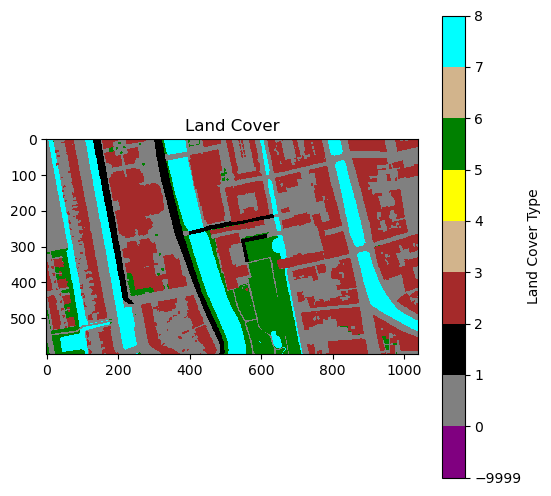

In [33]:
landcover = LandCover(bbox, building_data=buildings.building_geometries, dataset_path="output/final_dtm1.tif",  buildings_path=None, layer=None)

In [32]:
landcover.save_raster('output/landcovertest4_wat.tif', False)

CPLE_AppDefinedError: Deleting output/landcovertest4_wat.tif failed: Permission denied